In [25]:
import numpy as np
import SimpleITK as sitk
import ants
import utils
from matplotlib import pyplot as plt

In [14]:
# --------------------------------------
# 1. Rigid registration
# --------------------------------------

gt_img = sitk.GetArrayFromImage(sitk.ReadImage('./data/gt.nii'))
recon = sitk.GetArrayFromImage(sitk.ReadImage('out/recon_360_5.nii'))
recon_reg_list = np.zeros_like(recon)

for i in range(5):
    # rigid registration via ants
    rigid_transform = ants.registration(fixed=ants.from_numpy(gt_img[i]), moving=ants.from_numpy(recon[i]), 
                                        type_of_transform='Rigid', interpolator='bSpline')
    recon_reg = rigid_transform['warpedmovout'].numpy()
    recon_reg_list[i] = recon_reg
    
# save
sitk.WriteImage(sitk.GetImageFromArray(np.array(recon_reg_list)), 'out/recon_reg_360_5.nii')

In [34]:
# --------------------------------------
# 2. PSNR and SSIM
# --------------------------------------

gt_img = sitk.GetArrayFromImage(sitk.ReadImage('./data/gt.nii'))
nuifft = sitk.GetArrayFromImage(sitk.ReadImage('data/nuifft_360_5.nii'))
recon_reg = sitk.GetArrayFromImage(sitk.ReadImage('out/recon_reg_360_5.nii'))

psnr_our_list = []
ssim_our_list = []

psnr_nuifft_list = []
ssim_nuifft_list = []
for i in range(5):
    psnr_our_list.append(utils.cal_psnr(ref=gt_img[i], img=recon_reg[i]))
    ssim_our_list.append(utils.cal_ssim(ref=gt_img[i], img=recon_reg[i]))
    
    psnr_nuifft_list.append(utils.cal_psnr(ref=gt_img[i], img=nuifft[i]))
    ssim_nuifft_list.append(utils.cal_ssim(ref=gt_img[i], img=nuifft[i]))
    
# metric
print(r'(NuIFFT) PSNR:{:.2f}, SSIM:{:.3f}'.format(np.mean(psnr_nuifft_list), np.mean(ssim_nuifft_list)))
print(r'(Moner) PSNR:{:.2f}, SSIM:{:.3f}'.format(np.mean(psnr_our_list), np.mean(ssim_our_list)))

(NuIFFT) PSNR:21.78, SSIM:0.328
(Moner) PSNR:32.53, SSIM:0.935


$\sigma_\vartheta$:0.008, $\sigma_\tau$:3.944


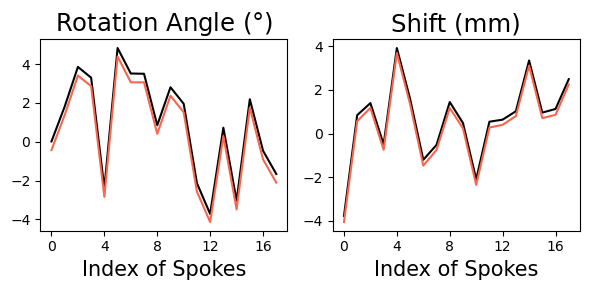

In [33]:
# --------------------------------------
# 2. Motion Meric and Visualization
# --------------------------------------

angle_motion = np.loadtxt('data/rot_360_5.txt')
shift_x = np.loadtxt('data/shift_x_360_5.txt')
shift_y = np.loadtxt('data/shift_y_360_5.txt')

angle_est = np.rad2deg(np.loadtxt('out/rot_360_5.txt'))
shift_x_est = np.loadtxt('out/shift_x_360_5.txt')
shift_y_est = np.loadtxt('out/shift_y_360_5.txt')

error_ang = angle_motion - angle_est
error_shift_x = shift_x-shift_x_est
error_shift_y = shift_y-shift_y_est
std_ang = np.mean(np.std(error_ang, axis=1))
std_shift_x = np.mean(np.std(error_shift_x, axis=1))
std_shift_y = np.mean(np.std(error_shift_y, axis=1))
print(r'$\sigma_\vartheta$:{:.3f}, $\sigma_\tau$:{:.3f}'.format(std_ang, (std_shift_x+std_shift_y)/2))

sample = 2
motion = np.array([angle_motion[sample], angle_est[sample],
                   shift_x[sample], shift_x_est[sample],
                   shift_y[sample], shift_y_est[sample]]).reshape(3, 2, -1)
title = [r'Rotation Angle ($\degree$)', r'Shift (mm)']
xticks = range(0, 18, 4)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
for i in range(2):
    if i == 0:
        ax[i].plot(motion[i, 0, :], color='#000000')
        ax[i].plot(motion[i, 1, :], color='#f9654d')
    else:
        ax[i].plot((motion[i, 0, :]+motion[i+1, 0, :])/2, color='#000000')
        ax[i].plot((motion[i, 1, :]+motion[i+1, 1, :])/2, color='#f9654d')
    ax[i].set_title(title[i], fontsize=17.5)
    ax[i].set_xlabel('Index of Spokes', fontsize=15)
    ax[i].set_xticks(xticks)
plt.tight_layout()
plt.show()